In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

cwd = os.getcwd()
save_dir = os.path.join(cwd,'\saves')
pics_dir = os.path.join(cwd,'\pics')


## System Dynamics Without Friction

### Example System Diagram
<img src='pics\cart_pole_diag_only.png'>

### Definitions
$x =$ position of the cart <br>
$\dot{x} =$ velocity of cart <br>
$\ddot{x} =$ acceleration of cart <br>
$\theta =$ angle of pole with respect to vertical <br>
$\dot{\theta} =$ angular velocity of pole <br>
$\ddot{\theta} =$ angular acceleration of pole <br>
$g =$ 9.81 $\frac{m}{s^2}$, acceleration due to gravity <br>
$M =$ 1.0 $kg$, mass of the cart <br>
$m =$ 0.1 $kg$, mass of the pole <br>
$L =$ 0.5 $m$, length of the pole <br>
$F =$ force applied to the cart $N$ <br>



### System
\begin{equation}
\big( M + m \big)\ddot{x} + m L \ddot{\theta}cos(\theta) - mL \dot{\theta}^2 sin(\theta) = F\\
mL\ddot{x} cos(\theta) + m L^2 \ddot{\theta} + mgL sin(\theta) = 0
\end{equation}

\begin{equation}
\implies \\
\boxed{\ddot{x} = \frac{F + m *sin(\theta) \big(L\dot{\theta}^2 + g* cos(\theta)\big)}{M + m*sin^2(\theta)}}\\
\boxed{\ddot{\theta} = \frac{-F*cos(\theta) - m L \dot{\theta}^2 sin(\theta)cos(\theta) - \big(M+m\big)g*sin(\theta)}{L\big(M+m*sin^2(\theta)\big)}}
\end{equation}


Converting to vector form:
\begin{equation}
X = \begin{bmatrix} x \\ \dot{x} \\ \theta \\ \dot{\theta} \end{bmatrix}, \text{ And, }\\
\dot{X} = \begin{bmatrix} \dot{x} \\ \ddot{x} \\ \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{x} \\  \frac{F + m *sin(\theta) \big(L\dot{\theta}^2 + g* cos(\theta)\big)}{M + m*sin^2(\theta)} \\ \dot{\theta} \\ \frac{-F*cos(\theta) - m L \dot{\theta}^2 sin(\theta)cos(\theta) - \big(M+m\big)g*sin(\theta)}{L\big(M+m*sin^2(\theta)\big)} \end{bmatrix} = \begin{bmatrix} \dot{x} \\  \frac{m *sin(\theta) \big(L\dot{\theta}^2 + g* cos(\theta)\big)}{M + m*sin^2(\theta)} \\ \dot{\theta} \\ \frac{-m L \dot{\theta}^2 sin(\theta)cos(\theta) - \big(M+m\big)g*sin(\theta)}{L\big(M+m*sin^2(\theta)\big)} \end{bmatrix} + \begin{bmatrix} 0 \\  \frac{1}{M + m*sin^2(\theta)} \\ 0 \\ \frac{-cos(\theta)}{L\big(M+m*sin^2(\theta)\big)} \end{bmatrix}F
\end{equation}

## Build simulation of non-linear model

In [2]:
'''Simulation Functions
'''

def dX_dt(t,X,M,m,L,g,F):
    '''Nonlinear System Model
    Desc: Calculate X dot for Odeint and Simulations
    Inputs: X = state variable vector (x,x dot,theta,theta dot)
            t =  time vector (sec)
            M = Mass of cart (kg)
            m = Mass of pole at center of mass (kg)
            L = Length from pivot to center of mass (meters)
            g = acceleration due to gravity (m/s^2)
            F = Force in the positive x direction on cart (N)
    Output: X_dot = derivative of state vector 
                    (x dot,x dbl dot, dot theta,theta dbl dot)
            
            uses: none'''
    
    # break out for clairity
    x,dx,theta,dtheta = X 

    # compute for speed
    S = np.sin(theta)
    C = np.cos(theta)
    
    # compute X dot
    dx_dt = dx
    ddx_dt = (F + m*S*(L*dtheta*dtheta + g*C))/(M + m*S*S)
    dtheta_dt = dtheta
    ddtheta_dt = ( -F*C - m*L*dtheta*dtheta*S*C - (M + m)*g*S )/(L*(M+m*S*S))
    
    X_dot = [dx_dt,ddx_dt,dtheta_dt,ddtheta_dt]
    return X_dot

def dX_dt_control(t,X,M,m,L,g,K):
    '''Nonlinear System Model with controller
    Desc: Calculate X dot for Odeint and Simulations With Control Law K
    Inputs: X = state variable vector (x,x dot,theta,theta dot)
            t =  time vector (sec)
            M = Mass of cart (kg)
            m = Mass of pole at center of mass (kg)
            L = Length from pivot to center of mass (meters)
            g = acceleration due to gravity (m/s^2)
            K = Control Law Matix
    Output: X_dot = derivative of state vector 
                    (x dot,x dbl dot, dot theta,theta dbl dot)
            
            uses: none'''
    
    # break out for clairity
    x,dx,theta,dtheta = X 
    
    #compute control law
    F = np.matrix(-K)*np.matrix(X).T

    # compute for speed
    S = np.sin(theta)
    C = np.cos(theta)
    
    # compute X dot
    dx_dt = dx
    ddx_dt = (F + m*S*(L*dtheta*dtheta + g*C))/(M + m*S*S)
    dtheta_dt = dtheta
    ddtheta_dt = ( -F*C - m*L*dtheta*dtheta*S*C - (M + m)*g*S )/(L*(M+m*S*S))
    
    X_dot = [dx_dt,ddx_dt,dtheta_dt,ddtheta_dt]
    return X_dot
#=================================================================================
from scipy.integrate import odeint, solve_ivp
def simulate(X0, t, M = 1, m = 0.1,
             L = 0.5,g = -9.8 ,F = 0):
    '''
    Desc: Simulate system Cart Pole System
    Inputs: X0 = initial conditions (x, x dot, theta, theta dot)
            t =  time vector (sec)
            M = Mass of cart (kg)
            m = Mass of pole at center of mass (kg)
            L = Length from pivot to center of mass (meters)
            g = acceleration due to gravity (m/s^2)
            K = Control Law Matrix for Force on Cart
    Output: x_pend = x coordinate of pendulum (np.array)
            y_pend = y coordinate of pendulum (np.array)
            x_cart = x coordinate of pendulem (np.array)
            X = state variable vector (x,x dot,theta,theta dot)
            uses: none
    '''
    # Constants
    params = (M,m,L,g,F)
    # run simulation and calculate other vars
    X = solve_ivp(dX_dt,(t[0],t[-1]),X0,t_eval = t, args=params,
                      method = 'RK23').y
    x_cart = X[0,:]
    y_pend = L*np.cos(X[2,:])
    x_pend = L*np.sin(X[2,:]) + X[0,:]
    return x_pend,y_pend,x_cart,X

#==============================================================

def simulateControl(X0, t, K, step=1e-4, M = 1,m = 0.1,
             L = 0.5,g = -9.8):
    '''
    Desc: Simulate system Cart Pole With Control System
    Inputs: X0 = initial conditions (x, x dot, theta, theta dot)
            t =  time vector (sec)
            step = min step size for solver
            M = Mass of cart (kg)
            m = Mass of pole at center of mass (kg)
            L = Length from pivot to center of mass (meters)
            g = acceleration due to gravity (m/s^2)
            K = Control Matrix for Force in the positive x direction on cart
    Output: x_pend = x coordinate of pendulum (np.array)
            y_pend = y coordinate of pendulum (np.array)
            x_cart = x coordinate of pendulem (np.array)
            X = state variable vector (x,x dot,theta,theta dot)
            uses: none
    '''
    # Constants
    params = (M,m,L,g,K)
    # run simulation and calculate other vars
    X = solve_ivp(dX_dt_control,(t[0],t[-1]),X0,t_eval = t, args=params,
                      method = 'RK23').y
    x_cart = X[0,:]
    y_pend = L*np.cos(X[2,:])
    x_pend = L*np.sin(X[2,:]) + X[0,:]
    return x_pend,y_pend,x_cart,X

from matplotlib import animation
from IPython.display import HTML
def buildAnimation(t,x_pend,y_pend,x_cart):
    '''
    Desc: Build Animation Object for Cart and Pendulum
    Input: t = time vector,
           x_pend = x coordinate of pendulum
           y_pend = y coordinate of pendulum
           x_cart = x coordinate of cart
    Output: animation object
    Uses: none
    '''
    # Build plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 1), ylim=(-1,1))
    ax.grid()

    # Init Objects for Animation
    cart, = ax.plot([],[],linestyle='None',marker='s', markersize=40,
                    markeredgecolor='k', color='r',markeredgewidth=2)
    mass, = ax.plot([],[],linestyle='None',marker='o', markersize=20,
                    markeredgecolor='k', color='b',markeredgewidth=1)
    line, = ax.plot([],[],'o-',color='k',lw=4, markersize=6,
                    markeredgecolor='k', markerfacecolor='k')
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)

    # Animation Functions
    def init():
        cart.set_data([],[])
        mass.set_data([],[])
        line.set_data([],[])
        time_text.set_text('')
        return line, cart, mass, time_text

    def animate(i):
        cart.set_data([x_cart[i],[0]])
        mass.set_data([x_pend[i]],[y_pend[i]])
        line.set_data([x_cart[i],x_pend[i]],[0,y_pend[i]])
        time_text.set_text(time_template % t[i])
        return line, cart, mass, time_text

    # Animate
    anim = animation.FuncAnimation(fig, animate, np.arange(0,len(t)),
                                    interval=42,blit=False,init_func=init)
    return anim


from matplotlib import colors as mcolors
from itertools import cycle
def plotState(t,X):
    '''
    Desc: Plots State Variables vs Time for Cart Pole Simulation
    Inputs: t = time vector
            X = state variable vector (x,x dot,theta,theta dot)
    Outputs: Plots
    Uses: 
    '''
    ROWS = 4
    COL = 1
    COLORS = cycle(mcolors.TABLEAU_COLORS.items())
    f, axes = plt.subplots(ROWS,COL,sharex=True)
    f.set_size_inches(10,5)
    axes = axes.flatten()
    T = ['Cart Position vs Time',
        'Cart Velocity vs Time',
        'Pole Angle vs Time',
        'Pole Angular Velocity vs Time']
    yl = ['Meters','Meters','Radians','Radians']

    for i in range(0,X.shape[0]):
        axes[i].plot(t,X[i,:],color=next(COLORS)[1])
        axes[i].set_title(T[i],fontweight='bold')
        axes[i].set_ylabel(yl[i])
        axes[i].grid()
    axes[-1].set_xlabel('Time (sec)')
    plt.tight_layout()
    
def plotStateForce(t,X,u):
    '''
    Desc: Plots State Variables and Force vs Time for Cart Pole Simulation
    Inputs: t = time vector
            X = state variable vector (x,x dot,theta,theta dot)
            K = control law matrix
    Outputs: Plots
    Uses: 
    '''
    ROWS = 5
    COL = 1
    COLORS = cycle(mcolors.TABLEAU_COLORS.items())
    f, axes = plt.subplots(ROWS,COL,sharex=True)
    f.set_size_inches(10,7)
    axes = axes.flatten()
    T = ['Cart Position vs Time',
        'Cart Velocity vs Time',
        'Pole Angle vs Time',
        'Pole Angular Velocity vs Time',
        'Force on Cart vs Time']
    yl = ['Meters','Meters','Radians','Radians','Newtons']

    for i in range(0,X.shape[0]):
        axes[i].plot(t,X[i,:],color=next(COLORS)[1])
        axes[i].set_title(T[i],fontweight='bold')
        axes[i].set_ylabel(yl[i])
        axes[i].grid()
        
    axes[-1].plot(t,u,color=next(COLORS)[1])
    axes[-1].set_title(T[-1],fontweight='bold')
    axes[-1].set_ylabel(yl[-1])
    axes[-1].grid()
    axes[-1].set_xlabel('Time (sec)')
    plt.tight_layout()

### Run Simulation No Initial Velocities and Pedulum Slightly Off Center

In [3]:
'''Simulate'''
X0 = [0,0,0.1,0]
t = np.linspace(0,10,10*24)

x_pend,y_pend,x_cart,X = simulate(X0,t)

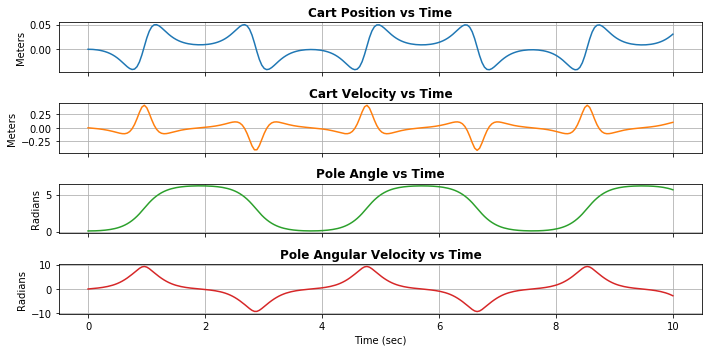

In [4]:
'''Plot State Variables from Simulation'''
plotState(t,X)
   

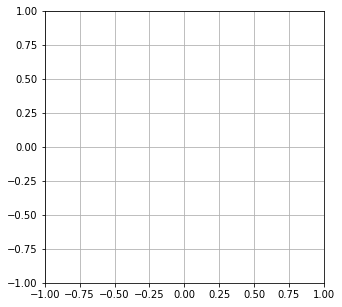

In [5]:
'''Build Animation Video'''
#%%capture junk
amin = buildAnimation(t,x_pend,y_pend,x_cart)

In [6]:
# Play Animation
HTML(amin.to_html5_video())

### To Use Linear Control Theory The System Must Be Linearized
Building the Jacobian,
\begin{equation}
\frac{\partial \dot{x}}{\partial x} = 0, \frac{\partial \dot{x}}{\partial \dot{x}} = 1, \frac{\partial \dot{x}}{\partial \theta} = 0, \frac{\partial \dot{x}}{\partial \dot{\theta}} = 0\\[20pt]
\frac{\partial \ddot{x}}{\partial x} = 0, \frac{\partial \ddot{x}}{\partial \dot{x}} = 0,\\
\frac{\partial \ddot{x}}{\partial \theta} = \frac{-m\Big(\big(mL\dot{\theta}^2*cos(\theta)+gm+2Mg\big) * sin^2(\theta )+2F*sin(\theta)cos(\theta)-ML\dot{\theta}^2*cos(\theta)-Mg\Big)}{(M + m*sin^2(\theta))^2}\\
\frac{\partial \ddot{x}}{\partial \dot{\theta}} = \frac{2mL*sin(\theta)*\dot{\theta}}{M + m*sin^2(\theta)}\\[20pt]
\frac{\partial \dot{\theta}}{\partial x} = 0, \frac{\partial \dot{\theta}}{\partial \dot{x}} = 0, \frac{\partial \dot{\theta}}{\partial \theta} = 0, \frac{\partial \dot{\theta}}{\partial \dot{\theta}} = 1\\[20pt]
\frac{\partial \ddot{\theta}}{\partial x} = 0, \frac{\partial \ddot{\theta}}{\partial \dot{x}} = 0,\\
\frac{\partial \ddot{\theta}}{\partial \theta} =  \frac{2m *cos(\theta ) *sin(\theta )((Lm\dot{\theta}^2 *cos(\theta )+gm+Mg ) *sin(\theta )+F *cos(\theta ) )}{L(M + m *sin^2(\theta ))^2}- \frac{-Lm\dot{\theta}^2 *sin^2(\theta )-F *sin(\theta )+ *cos(\theta )(Lm\dot{\theta}^2 *cos(\theta )+gm+Mg )}{L(M + m *sin^2(\theta ))}\\ 
\frac{\partial \ddot{\theta}}{\partial \dot{\theta}} = -\frac{2m*cos(\theta)*sin(\theta)*\dot{\theta}}{M + m*sin^2(\theta)}
\end{equation}

## Construct Linearized System and Non-algorithmic Pole Placement Controller

In [7]:
'''Build '''
M,m,L,g,F = 1,0.1,0.5,-9.8,0
A = np.matrix([[0,1,0,0],[0,0,m*g/M,0],[0,0,0,1],[0,0,-g*(M+m)/L/M,0]])
B = np.matrix([[0],[1/M],[0],[-1/L/M]])

In [8]:
import control

'''Get Controllabiltiy Matrix Using Library'''
CM = control.ctrb(A,B)

# calculation of controllability matrix by hand
CM2 = np.hstack((B,A*B,A*A*B,A*A*A*B))

print('Controllabiltiy Matrix from Library')
display(CM)
print('Controllabiltiy Matrix by hand')
display(CM2)


Controllabiltiy Matrix from Library


matrix([[  0.  ,   1.  ,   0.  ,   1.96],
        [  1.  ,   0.  ,   1.96,   0.  ],
        [  0.  ,  -2.  ,   0.  , -43.12],
        [ -2.  ,   0.  , -43.12,   0.  ]])

Controllabiltiy Matrix by hand


matrix([[  0.  ,   1.  ,   0.  ,   1.96],
        [  1.  ,   0.  ,   1.96,   0.  ],
        [  0.  ,  -2.  ,   0.  , -43.12],
        [ -2.  ,   0.  , -43.12,   0.  ]])

In [9]:
'''Controlability Requires Controlability matrix be of full rank'''
print('Controllability Matrix Rank: ',np.linalg.matrix_rank(CM))

'''Eigenvalues of A, positive is unstable, has one unstable eigen value and one stable'''
print('A matrix eigenvalues: ',np.linalg.eigvals(A))

Controllability Matrix Rank:  4
A matrix eigenvalues:  [ 0.          0.          4.64327471 -4.64327471]


In [10]:
'''Design a control law u = -Kx, by pole placement'''
k1 = [-0.6,-0.8,-1,-1.2]
print('Place Poles at: ',k1)

K = control.place(A,B,k1)
print('Resulting K matrix: ',K)

'''Designed system has response X dot = (A - BK)x'''
print('Check Designed system has response eig(A - BK): ',np.linalg.eigvals(A-B*K))


Place Poles at:  [-0.6, -0.8, -1, -1.2]
Resulting K matrix:  [[ -0.02938776  -0.13959184 -13.17469388  -1.86979592]]
Check Designed system has response eig(A - BK):  [-1.2 -1.  -0.8 -0.6]


## Simulate Non-algorithmic Pole Placement Controller

In [11]:
'''now simulate with F = -K*(X - X_desired)'''
'''Simulate'''
X0 = [-0.75,0,0.1,0]
t = np.linspace(0,15,15*24)
x_pend,y_pend,x_cart,X = simulateControl(X0,t,K)

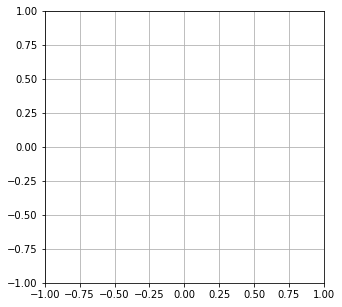

In [12]:
#%%capture junk
amin = buildAnimation(t,x_pend,y_pend,x_cart)

In [13]:
HTML(amin.to_html5_video())

## Linear Qudratic Regualtor Design

In [14]:
'''Cost matrix for state variables
 x, xdot, theta, theta dot'''
Q = np.diagflat([100,1,10,1])
print('State Variable Cost Matrix:\n',Q)

''' Cost matrix for manipulated variable
'''
R = np.matrix([0.01])
print('\nCost matrix for manipulated variable:\n',R)

State Variable Cost Matrix:
 [[100   0   0   0]
 [  0   1   0   0]
 [  0   0  10   0]
 [  0   0   0   1]]

Cost matrix for manipulated variable:
 [[0.01]]


### Function to build LQR from http://www.mwm.im/lqr-controllers-with-python/

In [15]:
from scipy.linalg import solve_continuous_are, inv, eig
def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.
    dx/dt = A x + B u
    cost = integral x.T*Q*x + u.T*R*u
    code from: http://www.mwm.im/lqr-controllers-with-python/
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(inv(R)*(B.T*X))

    eigVals, eigVecs = eig(A-B*K)
    return K, eigVals

### Calculate LQR control law, K

In [16]:
K, ev = lqr(A,B,Q,R)
print('LQR K matrix:\n',K)

LQR K matrix:
 [[-100.          -66.45010144 -222.24518312  -50.46585068]]


## Simulate LQR Response

In [17]:
'''now simulate with F = -K*(X - X_desired)'''
'''Simulate'''
X0 = [-0.75,0,0.1,0]
t = np.linspace(0,3,3*24)
x_pend,y_pend,x_cart,X = simulateControl(X0,t,K)

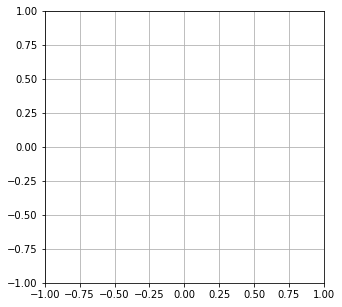

In [18]:
#%%capture junk
amin = buildAnimation(t,x_pend,y_pend,x_cart)

In [19]:
HTML(amin.to_html5_video())

## Plot State Variables and Force for LQR Simulation

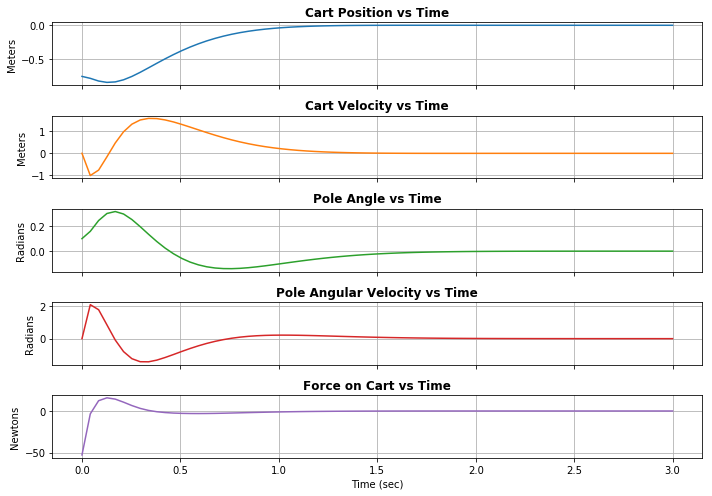

In [20]:
u = (-K*X).T
plotStateForce(t,X,u)